# Chapters 18: Clustering

In [2]:
# Basic Libraries

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

import pandas as pd
import numpy as np

In [3]:
# Specific Libraries

from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree
)

### The Dataset

In [5]:
# Titanic Dataset

url = ("https://raw.githubusercontent.com/joanby/python-ml-course/refs/heads/master/datasets/titanic/titanic3.csv")
df = pd.read_csv(url)
orig_df = df
orig_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


Here is a summary of all dataset treatments; for more details, see MLPR 01 and MLPR 02.

In [7]:
from sklearn import model_selection 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer  
from sklearn.preprocessing import StandardScaler 

def tweak_titanic(df):
    # Drop unnecessary columns and convert categorical columns to dummy variables
    df = df.drop(
        columns=[
            "name",          # Drop passenger name column
            "ticket",        # Drop ticket column
            "home.dest",     # Drop home destination column
            "boat",          # Drop boat information column
            "body",          # Drop body number column
            "cabin",         # Drop cabin information column
        ]
    ).pipe(pd.get_dummies, drop_first=True)  # Convert categorical variables to dummy variables, dropping the first category
    return df                                # Return the cleaned and transformed DataFrame

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]               # Extract the target variable
    X = df.drop(columns=y_col)  # Drop target variable from feature set
    
    X_train, X_test, y_train, y_test = model_selection.train_test_split(   # Split data into training and test sets
        X, y, test_size=size, random_state=42
    )
    cols = X.columns  # Get list of feature columns
    
    num_cols = [      # List of numeric columns to impute for missing values
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = IterativeImputer()                       # Initialize IterativeImputer for imputing missing values
    fitted = fi.fit_transform(X_train[num_cols])  # Fit and transform imputer on training numeric columns
    
    # Update training DataFrame with imputed values for numeric columns
    X_train = X_train.assign(**{c: fitted[:, i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])  # Transform test data using the same imputer
    
    # Update test DataFrame with imputed values for numeric columns
    X_test = X_test.assign(**{c: test_fit[:, i] for i, c in enumerate(num_cols)})
    
    # Standardize specified columns if any are provided
    if std_cols:
        std = StandardScaler()  # Initialize StandardScaler
        fitted = std.fit_transform(X_train[std_cols])  # Fit and transform scaler on training standardization columns
        # Update training DataFrame with standardized values
        X_train = X_train.assign(**{c: fitted[:, i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])     # Transform test data using the same scaler
        # Update test DataFrame with standardized values
        X_test = X_test.assign(**{c: test_fit[:, i] for i, c in enumerate(std_cols)})

    # Return training and test sets for features and target
    return X_train, X_test, y_train, y_test

# Apply the functions to preprocess the Titanic dataset
ti_df = tweak_titanic(orig_df)                 # Clean and transform the original DataFrame
std_cols = "pclass,age,sibsp,fare".split(",")  # Specify columns to standardize

# Split the preprocessed data into training and test sets
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

# Concatenate training and test sets for features and target variables for further use
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

### K-Means

In [9]:
from sklearn.cluster import KMeans

# Standardize the feature matrix 'X' to have a mean of 0 and a standard deviation of 1
X_std = preprocessing.StandardScaler().fit_transform(X)

# Initialize the KMeans model with 2 clusters and set a random state for reproducibility
km = KMeans(2, random_state=42)

# Fit the KMeans model to the standardized feature matrix
km.fit(X_std)

KMeans(n_clusters=2, random_state=42)

In [10]:
# Predict the cluster labels for the standardized feature matrix 'X' using the fitted KMeans model
X_km = km.predict(X.values)  # Use .values to remove feature names

# Display the predicted cluster labels
X_km

array([1, 1, 1, ..., 1, 1, 1])

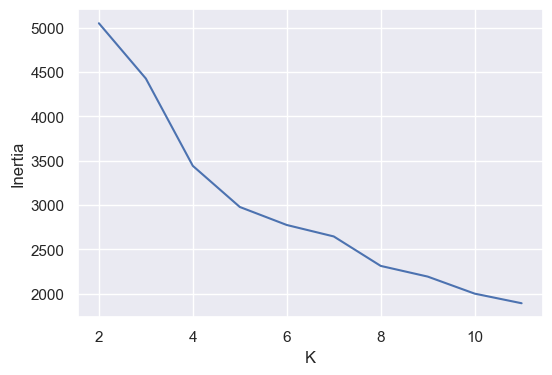

In [11]:
inertias = []         # Initialize an empty list to store inertia values for each k
sizes = range(2, 12)  # Define the range of cluster sizes (k) to test, from 2 to 11

# Loop through each cluster size (k) and fit the KMeans model
for k in sizes:
    k2 = KMeans(random_state=42, n_clusters=k)  # Initialize KMeans with a specific k and random state for reproducibility
    k2.fit(X)                                   # Fit the KMeans model to the data X
    inertias.append(k2.inertia_)                # Append the inertia (sum of squared distances of samples to their closest cluster center) to the list

# Plot the inertia values for each k
fig, ax = plt.subplots(figsize=(6, 4))        # Create a figure and axis with specified size
pd.Series(inertias, index=sizes).plot(ax=ax)  # Plot inertia values as a series with k as the index
ax.set_xlabel("K")                            # Set the x-axis label to "K" (number of clusters)
ax.set_ylabel("Inertia");                     # Set the y-axis label to "Inertia"

#fig.savefig("images/mlpr_1801.png", dpi=300)

The Inertia provided us the **Elbow Method**. 

The **Silhouette Coefficient** is a value between -1 and 1. The higher the score, the better. 1 indicates tight clusters, and 0
means overlapping clusters. From that measure, two clusters gives us the best score.

The **Calinski-Harabasz Index** is the ratio of between-cluster dispersion and within-cluster dispersion. A higher score is better. Two clusters gives the best score for this metric.

The **Davis-Bouldin Index** is the average similarity between each cluster and the closest cluster. Scores range from 0 and up. 0 indicates better clustering.

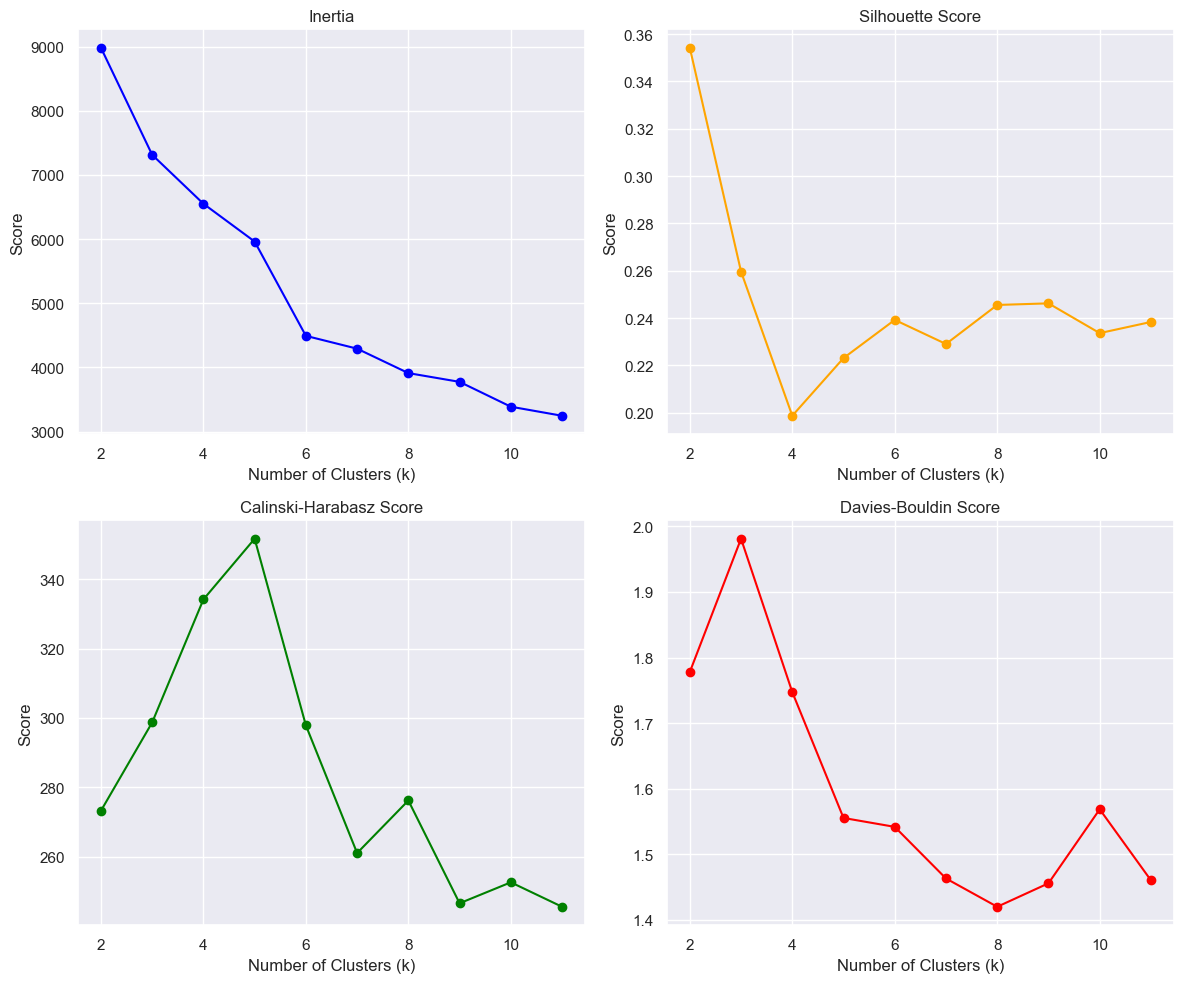

In [13]:
from sklearn import metrics

# Initialize lists to store evaluation metrics for each k
inertias = []
sils = []  # Silhouette scores
chs = []   # Calinski-Harabasz scores
dbs = []   # Davies-Bouldin scores

sizes = range(2, 12)  # Range of cluster sizes (k) to evaluate

# Loop through each cluster size (k) and fit the KMeans model
for k in sizes:
    k2 = KMeans(random_state=42, n_clusters=k)  # Initialize KMeans with specified k and random state
    k2.fit(X_std)  # Fit the model to the standardized data (X_std)
    
    # Append the inertia (sum of squared distances of samples to their closest cluster center)
    inertias.append(k2.inertia_)
    
    # Calculate and append silhouette score
    sils.append(metrics.silhouette_score(X, k2.labels_))
    
    # Calculate and append Calinski-Harabasz score
    chs.append(metrics.calinski_harabasz_score(X, k2.labels_))
    
    # Calculate and append Davies-Bouldin score
    dbs.append(metrics.davies_bouldin_score(X, k2.labels_))

# Create subplots for the different metrics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Create a 2x2 grid of subplots with specified size
ax1, ax2, ax3, ax4 = axes.ravel()                 # Unpack the subplots into individual axes

# Plot each metric on its respective subplot with the specified colors
pd.Series(inertias, index=sizes).plot(ax=ax1, title='Inertia', color='blue', marker='o')
pd.Series(sils, index=sizes).plot(ax=ax2, title='Silhouette Score', color='orange', marker='o')
pd.Series(chs, index=sizes).plot(ax=ax3, title='Calinski-Harabasz Score', color='green', marker='o')
pd.Series(dbs, index=sizes).plot(ax=ax4, title='Davies-Bouldin Score', color='red', marker='o')

# Set labels for each subplot
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlabel("Number of Clusters (k)")
    ax.set_ylabel("Score")

plt.tight_layout()  # Adjust layout to prevent overlap
# plt.savefig("images/mlpr_1802.png", dpi=300)
plt.show()          # Display the plots

Another technique for determining clusters is to visualize the silhouette scores for each cluster. Yellowbrick has a visualizer for this.

The vertical dotted red line in this plot is the average score. One way to interpret it is to make sure that each cluster bumps
out above the average, and the cluster scores look decent. Make sure you are using the same x limits (`ax.set_xlim`). I would choose two clusters from these plots:

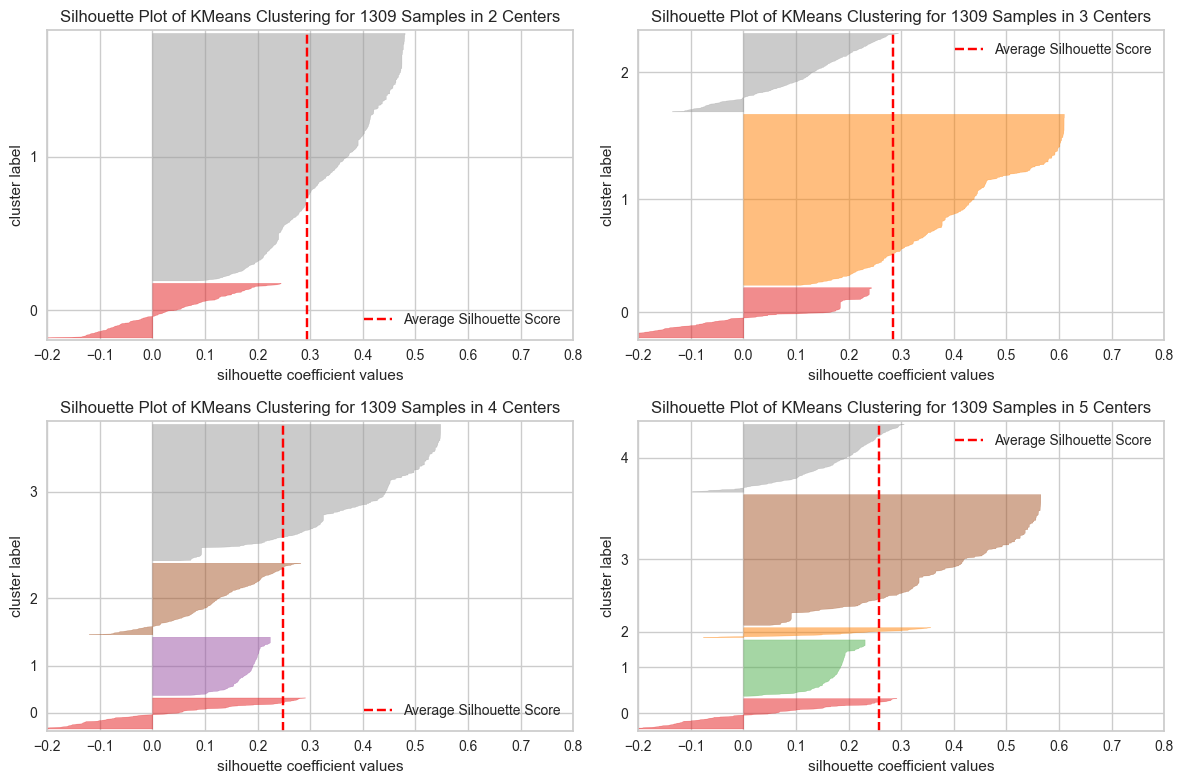

In [15]:
from yellowbrick.cluster.silhouette import SilhouetteVisualizer

# Create a 2x2 grid of subplots with a figure size of 12x8 inches
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.reshape(4)                          # Flatten the 2x2 array of axes into a 1D array for easy iteration

# Iterate over the range of cluster numbers (k) from 2 to 5 and enumerate them for indexing
for i, k in enumerate(range(2, 6)):
    ax = axes[i]                                # Get the current subplot axis
    sil = SilhouetteVisualizer(                 # Create a SilhouetteVisualizer instance for silhouette analysis
        KMeans(n_clusters=k, random_state=42),  # Use KMeans clustering with the current number of clusters and set random state for reproducibility
        ax=ax,                                  # Pass the current axis to the visualizer
    )
    sil.fit(X_std)          # Fit the visualizer with the standardized data (X_std)
    sil.finalize()          # Finalize the plot by setting labels and titles
    ax.set_xlim(-0.2, 0.8)  # Set the x-axis limits to enhance visibility across subplots

plt.tight_layout()          # Adjust subplot parameters to prevent overlapping plots

fig.savefig("silhouette_scores.png", dpi=300)

#### General Insights:

* The ideal number of clusters maximizes the average silhouette score while maintaining well-defined clusters without too much variation within them.
* k = 2 and k = 3 appear to be the most promising solutions, as they have higher average silhouette scores and fewer poorly clustered points compared to k = 4 or k = 5.
* k = 5 shows that adding more clusters beyond a certain point can lead to poorly defined clusters and lower average silhouette scores.

#### Conclusion:

Based on these plots, k = 2 or k = 3 seem to be the best choices for clustering, with k = 3 providing a more granular division without significantly sacrificing the average silhouette score. Increasing the number of clusters beyond that point may not yield better clustering quality and may lead to overfitting or less meaningful groupings.

### Agglomerative (Hierarchical) Clustering

Agglomerative clustering is another methodology. You start off with each sample in its own cluster. Then you combine the “nearest” clusters. Repeat until done while keeping track of the nearest sizes.

When you have finished this, you will have a dendrogram, or a tree that tracks when clusters were created and what the distance metric was. You can use the scipy library to visualize the dendrogram.

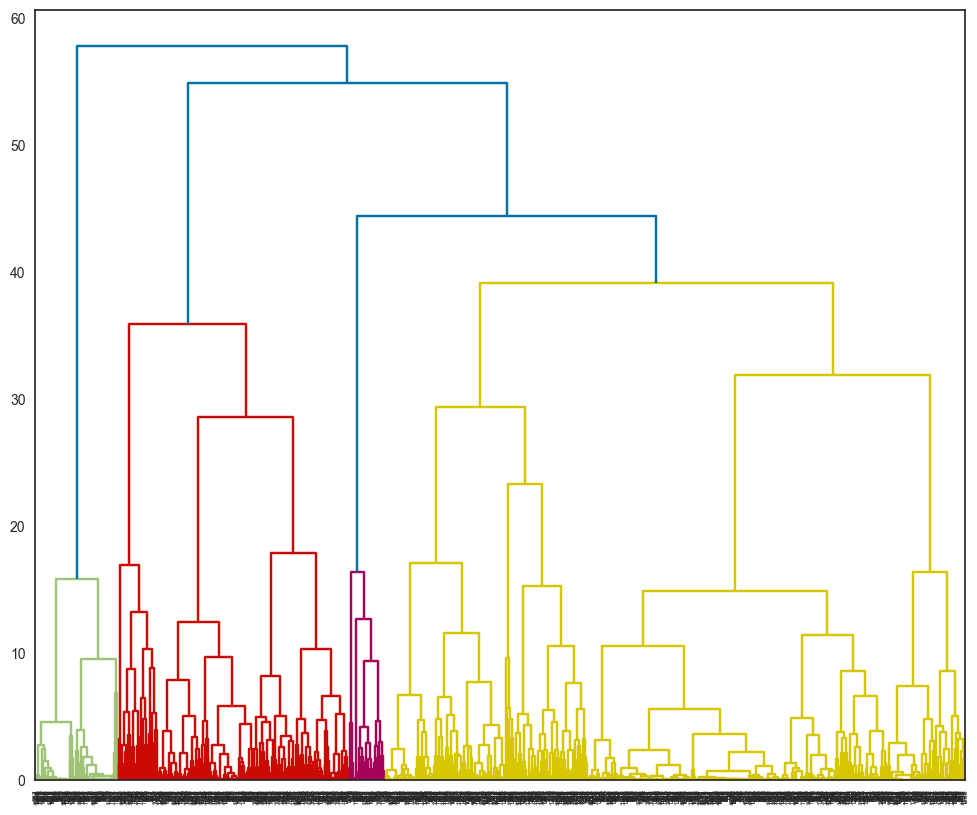

In [18]:
from scipy.cluster import hierarchy

sns.set_style("white")                    # Set the Seaborn plot style to 'white' for a clean background

fig, ax = plt.subplots(figsize=(12, 10))  # Create a figure and axes object with a size of 12x10 inches
dend = hierarchy.dendrogram(              # Plot a hierarchical clustering dendrogram
    hierarchy.linkage(X_std,              # Compute the linkage matrix using the standardized data 'X_std'
                      method="ward"))     # Use the 'ward' method for calculating distances between clusters

The previous plot was a little noisy with all of the samples in it. You can also use the `truncate_mode` parameter to combine the leaves into a single node:

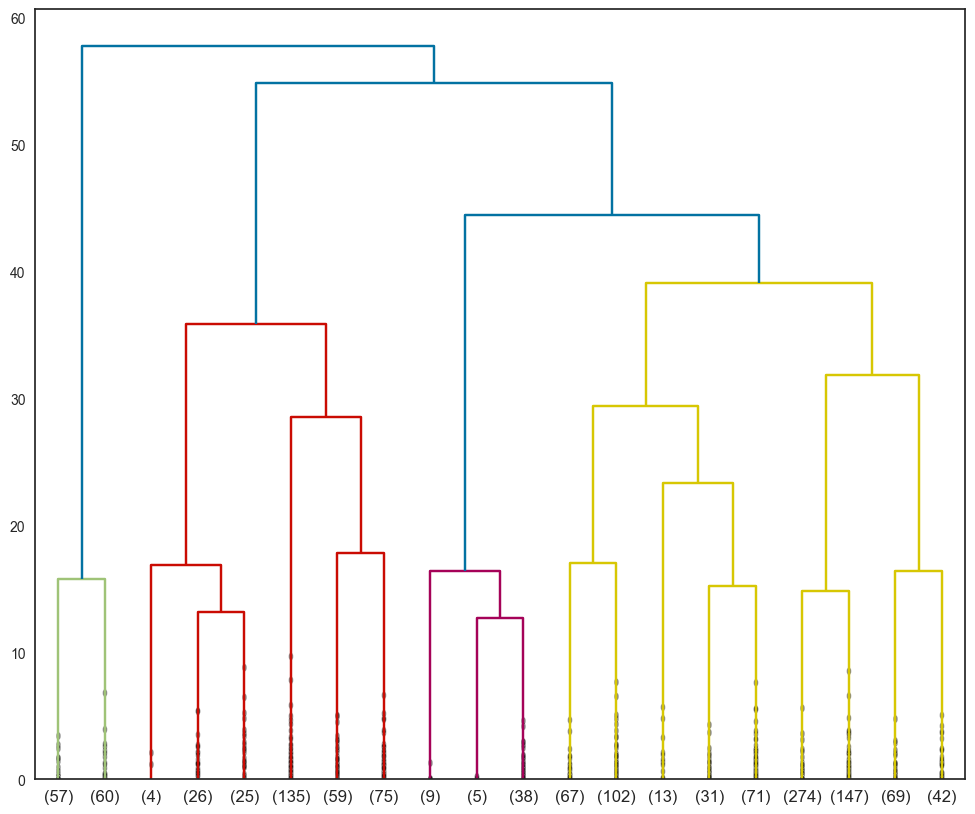

In [20]:
from scipy.cluster import hierarchy

fig, ax = plt.subplots(figsize=(12, 10))      # Create a figure and axes object with a size of 12x10 inches
dend = hierarchy.dendrogram(                  # Plot a hierarchical clustering dendrogram
    hierarchy.linkage(X_std, method="ward"),  # Compute the linkage matrix using the standardized data 'X_std' and 'ward' method
    truncate_mode="lastp",                    # Truncate the dendrogram to only show the last 'p' merged clusters
    p=20,                                     # Show the last 20 clusters in the dendrogram
    show_contracted=True)                     # Display contracted branches (collapsed version) in the dendrogram

*Truncated hierarchical clustering dendrogram. If we cut across the largest vertical lines, we get three clusters.*

Once we know how many clusters we need, we can use scikitlearn to create a model:

In [23]:
from sklearn.cluster import AgglomerativeClustering

ag = AgglomerativeClustering(  # Initialize the AgglomerativeClustering model
    n_clusters=4,              # Specify the number of clusters to form (4 in this case)
    linkage="ward")            # Use the Ward linkage criterion for minimizing variance within clusters

ag.fit(X)                      # Fit the model to the data 'X'

AgglomerativeClustering(n_clusters=4)

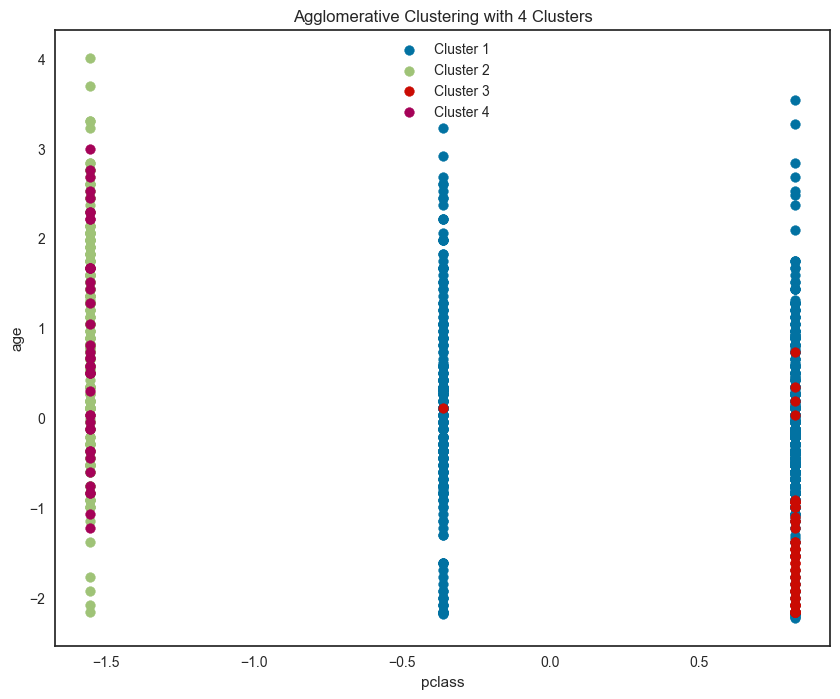

In [24]:
y_pred = ag.fit_predict(X)

# Create a scatter plot of the clustering results
fig, ax = plt.subplots(figsize=(10, 8))

# Plot each cluster with a different color
for cluster in range(4):
    ax.scatter(
        X.iloc[y_pred == cluster, 0],  # Select the rows of the first feature for the current cluster
        X.iloc[y_pred == cluster, 1],  # Select the rows of the second feature for the current cluster
        label=f'Cluster {cluster + 1}'
    )

# Customize the plot
ax.set_title("Agglomerative Clustering with 4 Clusters")
ax.set_xlabel(X.columns[0])  # Label for the x-axis
ax.set_ylabel(X.columns[1])  # Label for the y-axis
ax.legend()                  # Display the legend

plt.show();                  # Display the plot

## Understanding Clusters

Using K-means on the Titanic dataset, we will make two clusters. We can use the grouping functionality in pandas to examine the differences in the clusters. The code below examines the
mean and variance for each feature. It appears that the mean value for pclass varies quite a bit.
    
I’m sticking the survival data back in to see if the clustering was related to that:

In [27]:
km = KMeans(n_clusters=2)   # Initialize the KMeans clustering model with 2 clusters
km.fit(X_std)               # Fit the KMeans model to the standardized data (X_std)
labels = km.predict(X_std)  # Predict the cluster labels for the standardized data

(X.assign(cluster=labels, survived=y)  # Add 'cluster' and 'survived' columns to the DataFrame
 .groupby("cluster")                   # Group by 'cluster'
 .agg(["mean", "var"])                 # Aggregate the data to get the mean and variance for each feature
 .T)                                   # Transpose the DataFrame for better visualization

cluster                 0         1
pclass     mean  0.190630 -0.054159
           var   0.764105  1.028504
age        mean -0.887836  0.243005
           var   1.221419  0.834363
sibsp      mean  1.070205 -0.262377
           var   3.017815  0.205222
parch      mean  1.850679  0.087316
           var   1.418511  0.088965
fare       mean  0.288588 -0.067762
           var   1.318128  0.867762
sex_male   mean  0.371041  0.699449
           var   0.234430  0.210414
embarked_Q mean  0.031674  0.106618
           var   0.030810  0.095338
embarked_S mean  0.819005  0.673713
           var   0.148910  0.220026
survived   mean  0.520362  0.353860
           var   0.250720  0.228854

In [28]:
# Highlight the high and low values of each row.

(X.assign(cluster=labels, survived=y)          # Add 'cluster' and 'survived' columns to the DataFrame
 .groupby("cluster")                           # Group by 'cluster'
 .agg(["mean", "var"])                         # Aggregate the data to get the mean and variance for each feature
 .T                                            # Transpose the DataFrame for better visualization
 .style                                        # Apply styling to the DataFrame
 .background_gradient(cmap='viridis', axis=1)  # Add background gradient with the specified color map
)

We can plot a bar plot of the means for each cluster:

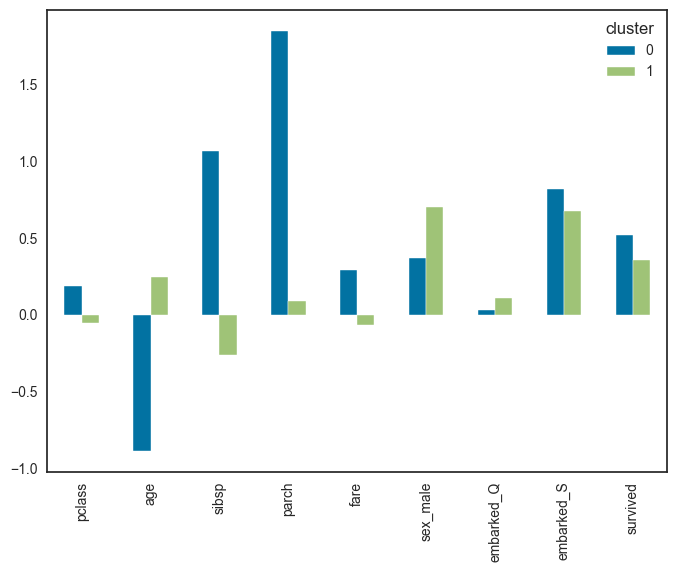

In [30]:
fig, ax = plt.subplots(figsize=(8, 6)) # Create a figure and axis
(X.assign(cluster=labels, survived=y)  # Add 'cluster' and 'survived' columns to 'X'
 .groupby("cluster")                   # Group the DataFrame by 'cluster'
 .mean()                               # Compute the mean for each feature within each cluster
 .T                                    # Transpose the DataFrame to have features on the x-axis
 .plot.bar(ax=ax));                    # Plot the transposed DataFrame as a bar plot on the axis

I also like to plot the PCA components, but colored by the cluster label. Here we use Seaborn to do that. It is
also interesting to change the values for hue to dive into the features that are distinct for the clusters.

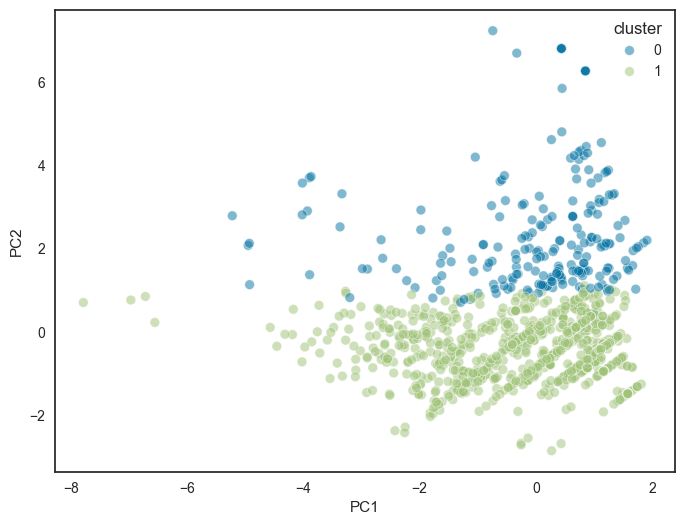

In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Initialize PCA with a set random state for reproducibility
pca = PCA(random_state=42)

# Apply StandardScaler to the data and then fit-transform using PCA
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))

# Create a scatter plot using seaborn
sns.scatterplot(
    x="PC1", 
    y="PC2",  
    data=X.assign(
        PC1=X_pca[:, 0],  # Assign PC1 to the DataFrame
        PC2=X_pca[:, 1],  # Assign PC2 to the DataFrame
        cluster=labels    # Add the cluster labels
    ),
    hue="cluster",  # Use cluster column to color the points
    alpha=0.5,      # Set transparency
    ax=ax);         # Specify the axis to plot on

*PCA plot of clusters*

If we want to examine a single feature, we can use the pandas `.describe` method:

In [35]:
(X.assign(cluster=labels) # Add a new column 'cluster' to the DataFrame using the clustering labels
 .groupby("cluster")      # Group the DataFrame by the 'cluster' column
 .age.describe()          # Generate descriptive statistics for the 'age' column within each cluster
 .T)                      # Transpose the result for better readability, displaying clusters as columns

cluster,0,1
count,221.000000,1088.000000
mean,-0.887836,0.243005
std,1.105178,0.913435
min,-2.221251,-2.201741
25%,-1.922105,-0.361333
50%,-0.985642,-0.049178
75%,-0.205255,0.789101
max,2.760212,4.008830


We can also create a surrogate model to explain the clusters.
Here we use a decision tree to explain them. This also shows
that pclass (which had a large difference in the mean) is very
important:

In [37]:
dt = tree.DecisionTreeClassifier()  # Create an instance of a Decision Tree Classifier

dt.fit(X, labels)                   # Train the classifier using the feature matrix X and cluster labels

for col, val in sorted(                       # Iterate through sorted pairs of column names and their feature importances
    zip(X.columns, dt.feature_importances_),  # Pair each column name with its corresponding importance
    key=lambda col_val: col_val[1],           # Sort pairs by the importance value
    reverse=True,                             # Sort in descending order (most important feature first)
):
    print(f"{col:10}{val:10.3f}")   # Print each feature name and its importance with formatting

parch          0.722
age            0.152
sibsp          0.057
sex_male       0.038
fare           0.022
embarked_Q     0.005
embarked_S     0.004
pclass         0.000


And we can visualize the decisions. It shows that
pclass is the first feature the surrogate looks at to make a
decision:

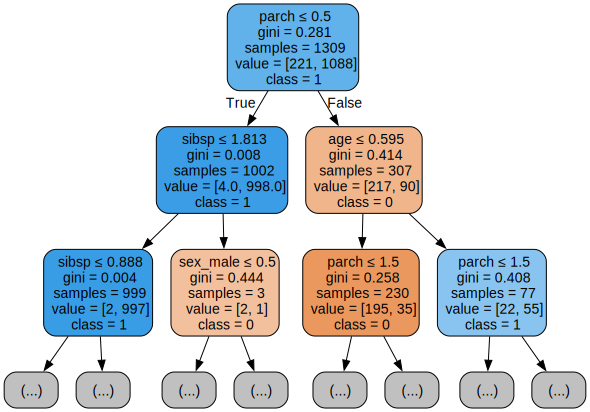

In [39]:
from sklearn import tree
import graphviz
from IPython.display import display

# Export the decision tree as a dot file
dot_data = tree.export_graphviz(
    dt,
    out_file=None,  # Export as a string
    feature_names=X.columns,
    class_names=["0", "1"],
    filled=True,
    rounded=True,
    special_characters=True,
    max_depth=2,  # Set max depth for visualization if needed
)

# Render the dot file using graphviz
graph = graphviz.Source(dot_data)
#graph.render("decision_tree")  # This saves the tree as a file (e.g., decision_tree.pdf)

# Display the plot directly in Jupyter Notebook
display(graph)

*Decision tree explaining the clustering*